In [1]:
### import packages here

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mwlmc import model as mwlmc_model
from mwlmc import util as mwlmc_util
from mwlmc import plot as mwlmc_plot


### Introduction

The simulations consists of expansion of the Milky Way stellar component 
(`mwd`), the Milky Way halo (`mwhalo`), and the Large Magellanic Cloud halo 
(`lmc`). In this tutorial, we present how we can run orbits in
the full simulation. For a tutorial on how to access the fields, see the 
[fields tutorial](fields_tutorial.ipynb). The advantage of this type of 
simulation is that we can select different moments (such as the dipole or 
quadrupole), and see how this affects all these outputs. For a more detailed 
explanation and example, see e.g.vLilleengen et al. 2022. We also provide the 
option to run orbits in the static, unperturbed Milky Way potential similar to 
the one from [Erkal et al. 2019](https://ui.adsabs.harvard.edu/link_gateway/2019MNRAS.487.2685E/doi:10.1093/mnras/stz1371).



Let's get started. To access the simulation, first, we need to initialize the 
expansions. Afterwards, the functions will be callable via the Model instance:

In [2]:
Model = mwlmc_model.MWLMC()

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


#### LMC orbit

To get the trajectory of the LMC, we call the `get_lmc_trajectory` function. 
If selecting a time step, make sure it is not too big:


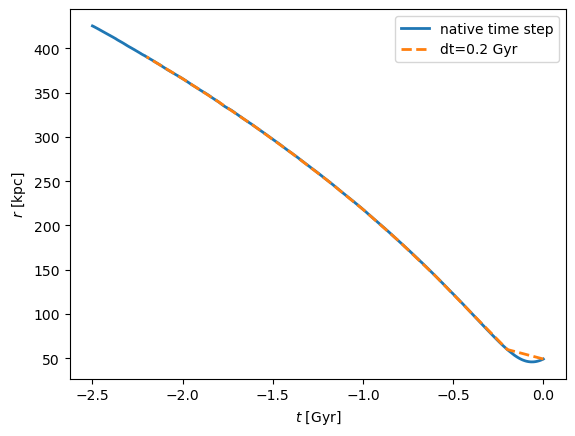

In [3]:
torb, lmcx, lmcy, lmcz = Model.get_lmc_trajectory().T
r = (lmcx**2 + lmcy**2 + lmcz**2)**(0.5)

fig, ax = mwlmc_plot.plot_orbit_time(torb, r, lw=2, label='native time step')

# As an example, a time step of 0.2 Gyr is too large:
torb_bad, lmcx_bad, lmcy_bad, lmcz_bad = Model.get_lmc_trajectory(dt = 0.2).T
r_bad = (lmcx_bad**2 + lmcy_bad**2 + lmcz_bad**2)**(0.5)

ax.plot(torb_bad, r_bad, ls='--', lw=2,  label='dt=0.2 Gyr')

plt.legend()
plt.show()

### Selecting different potentials
This simulation allows us to run orbits in different potential setup by 
selecting different harmonic moments, To do so, we can use the `lmcharmonicflag` 
for the LMC (and `mwhharmonicflag` for the `mwhalo` and `mwdharmonicflag` for 
the `mwd`). These flags are unique to the moments we want to choose (by default,
the fully live versions are selected). We can select up to the $l=6$ order in 
any combination we want (with the monopole always being selected). 
The `mwlmc_util.get_harmonic_flag` function returns the flag for our selection. 
If we e.g. want to choose only the even moments $l=(2,4,6)$ we can call the command in the following cell.

In [4]:
flag = mwlmc_util.get_harmonic_flag([2,4,6])
print(flag)

42


The flag for the monopole is $0$, the flag for the dipole is one, the flag for 
the quadrupole is $2$. The flag for combining dipole and quadrupole is $3$. 
For all higher flag best use the function. The flag for the live potential is 
$63$ or if the harmonic flag is not specified.

### Rewind orbits in the simulation 

#### Sun-like orbit in the live simulation: **Caution!**

We start with the orbits at their current positions and rewind them in the 
potential we choose (default: live). The rewind function takes cartesian 
coordinates $[x, y, z]$, $[v_x, v_y, v_z]$. The rewind time is positive. Any 
time before the simulation will be interpolated. `rewind` returns the positions, velocities, forces, and time at each time step. We now look at a Sun-like orbit:

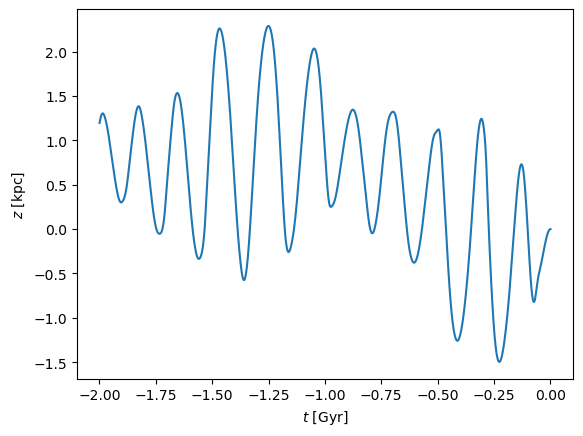

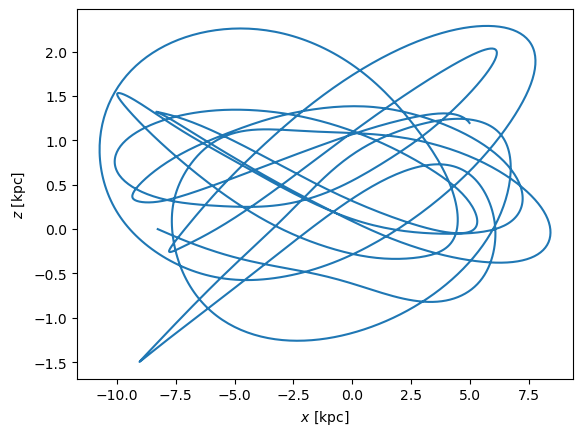

In [5]:
xsun = np.array([-8.27,0.,0.])
vsun = np.array([0.,200.,0.])

orbit = Model.rewind(xsun, vsun,
                     rewindtime=2.0, dt=0.001)

ox, oy, oz = orbit[0], orbit[1], orbit[2]
ovx, ovy, ovz = orbit[3], orbit[4], orbit[5]
ofx, ofy, ofz = orbit[6], orbit[7], orbit[8]
ot = orbit[9]

fig, ax = mwlmc_plot.plot_orbit_time(ot, oz, 'z')
fig, ax = mwlmc_plot.plot_orbit(ox, oz, 'x', 'z')
plt.show()

Looking at the evolution of the $z$-position of a Sun-like particle and of its 
orbit, we need to call for **caution when integrating orbits (and analysing 
fields) in the inner Milky Way!!** 

#### $N$ orbits in the live halo

Again, we can rewind $N$ initial conditions. The position and the velocity
inputs need to have the shape $(N, 3)$. Let's have a look at some particles
initialised out of the disc plane:

In [6]:
norbits = 10
pos = np.zeros([norbits,3])
vel = np.zeros([norbits,3])

for n in range(0,norbits):
    pos[n] = [0.1,1,1.+2*n]
    vel[n] = [100.,110.,10.]

print(np.shape(pos))
X = Model.rewind(pos, vel,
                 mwhharmonicflag=63,
                 rewindtime=2.5, dt=0.001)

X = np.array(X)

(10, 3)


This is the output of the functions for all $N$ orbits:

x, y, z  = `X[:,0]`, `X[:,1]`, `X[:,2]` \
vx, vy, vz = `X[:,3]`, `X[:,4]`, `X[:,5]`  \
fx, fy, fz = `X[:,6]`, `X[:,7]`, `X[:,8]` \
time = `X[:, 9]`


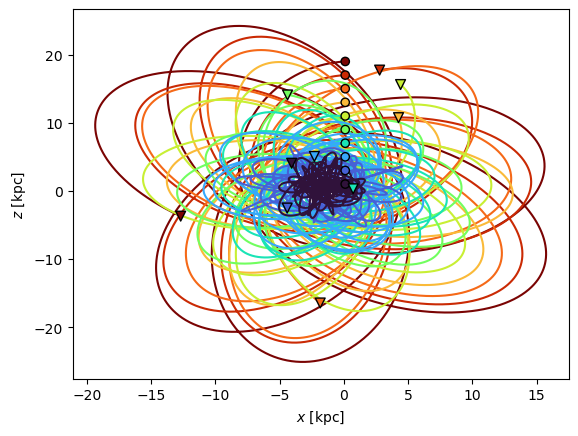

In [7]:
colors = plt.cm.turbo(np.linspace(0, 1, norbits))

fig, ax = plt.subplots()

# plot all orbits 
for i in range(norbits)[::-1]:
    ax.plot(X[:,0][i], X[:,2][i], 
            c=colors[i], zorder=20-i)
    
# plot start position
ax.scatter(X[:,0][:,0], X[:,2][:,0], 
           c=colors, marker='o', 
           edgecolors='k', zorder=50)

# plot end position
ax.scatter(X[:,0][:,-1], X[:,2][:,-1], 
           c=colors, marker='v', s=50, 
           edgecolors='k', zorder=50)

ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')
plt.show()

#### Comparison of orbits in different potentials 

Let's compare a halo orbit in the monopole `(mwhharmonicflag=0)`, dipole `(mwhharmonicflag=1)`, and live potential `(mwhharmonicflag=63)`:

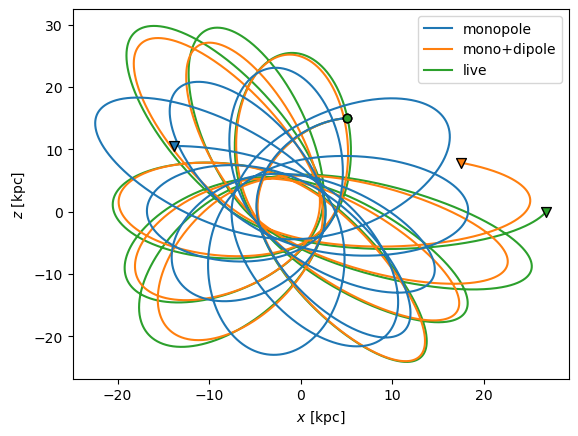

In [8]:
xsun = [5,10.,15.]
vsun = [100.,100.,10.]

flags = [0, 1, 63]
# fig, ax = plt.subplots()
labels = ['monopole', 'mono+dipole', 'live']

for i, flag in enumerate(flags):
    orbit = Model.rewind(xsun, vsun,
                         mwhharmonicflag=flag, 
                         rewindtime=4, dt=0.001)

    ox, oy, oz = orbit[0], orbit[1], orbit[2]
    ovx, ovy, ovz = orbit[3], orbit[4], orbit[5]
    ofx, ofy, ofz = orbit[6], orbit[7], orbit[8]
    ot = orbit[9]

    if i ==0:
        fig, ax = mwlmc_plot.plot_orbit(ox, oz, 'x', 'z', c='C'+str(i), zorder=20-i, label=labels[i])
    else:
        fig, ax = mwlmc_plot.plot_orbit(ox, oz, 'x', 'z', fig=fig, c='C'+str(i), zorder=20-i, label=labels[i])

    # plot start position
    ax.scatter(ox[0], oz[0], 
               c='C'+str(i), marker='o', 
               edgecolors='k', zorder=50)

    # plot end position
    ax.scatter(ox[-1], oz[-1], 
               c='C'+str(i), marker='v', s=50, 
               edgecolors='k', zorder=50)

ax.legend()
plt.show()

Even though the orbits follow a similar pattern, they end up being very offset 
from each other!

### Orbits in a static potential 

We also provide the possibility to evolve orbits in the static Milky Way that 
is the best approximation to the Milky Way of [Erkal et al. 2019](https://ui.adsabs.harvard.edu/link_gateway/2019MNRAS.487.2685E/doi:10.1093/mnras/stz1371) that is not perturbed by the LMC. This is done with the `mworbit` function, in
the same way as the `rewind` function:

fullintegrate.h: tvirbegin is less than 0! --> -0.941971


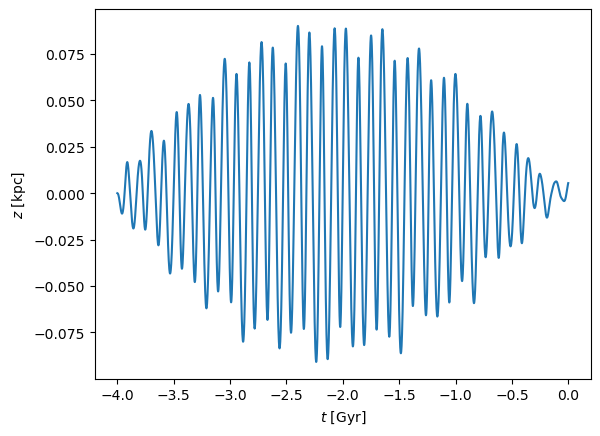

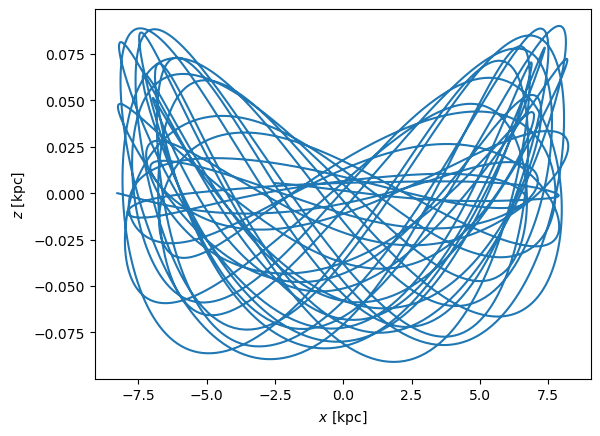

In [9]:
xsun = np.array([-8.27,0.,0.])
vsun = np.array([0.,200.,0.])

orbit = Model.mworbit(xsun, -vsun,
                      tbegin=-4, dt=0.001)

ox, oy, oz = orbit[0], orbit[1], orbit[2]
ovx, ovy, ovz = orbit[3], orbit[4], orbit[5]
ofx, ofy, ofz = orbit[6], orbit[7], orbit[8]
ot = orbit[9]

fig, ax = mwlmc_plot.plot_orbit_time(ot, oz, 'z')
fig, ax = mwlmc_plot.plot_orbit(ox, oz, 'x', 'z')
plt.show()

This seems to be a more regular orbit. 

Again, let's look at an array of orbits:

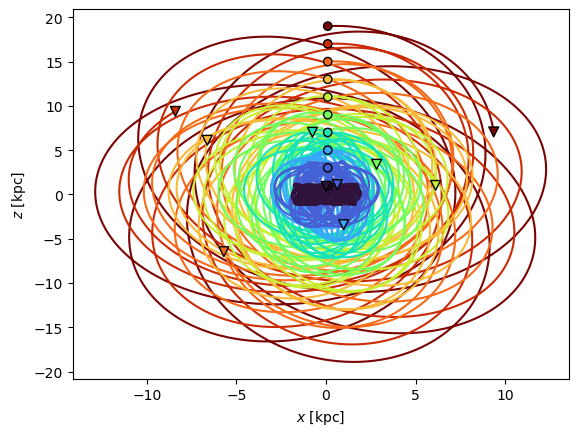

In [10]:
norbits = 10
pos = np.zeros([norbits,3])
vel = np.zeros([norbits,3])

for n in range(0,norbits):
    pos[n] = [0.1,1,1.+2*n]
    vel[n] = [100.,110.,10.]

X = Model.mworbit(pos, vel,
                  tbegin=-2.5, dt=0.001)
X = np.array(X)

colors = plt.cm.turbo(np.linspace(0, 1, norbits))

fig, ax = plt.subplots()

# plot all orbits 
for i in range(norbits)[::-1]:
    ax.plot(X[:,0][i], X[:,2][i], 
            c=colors[i], zorder=20-i)
    
# plot start position
ax.scatter(X[:,0][:,0], X[:,2][:,0], 
           c=colors, marker='o', 
           edgecolors='k', zorder=50)

# plot end position
ax.scatter(X[:,0][:,-1], X[:,2][:,-1], 
           c=colors, marker='v', s=50, 
           edgecolors='k', zorder=50)

ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')
plt.show()

We have used the same initial conditions as for the $N$ orbits in the live
potential. Just comparing these two plots, we see a significant difference in 
the orbits.

### Example: Crater 2 - small observational uncertainties 

We now give two examples of dwarf galaxies. There are several interesting
aspects to look at. How do orbits in the monopole vs the live potential differ?
How does this compare to orbits randomly drawn from the observational 
uncertainty? Is there a difference between Milky Way and LMC satellites?


The first example is for is Crater 2, which has 
relatively small errors. The data is taken from [McConnachie & Venn 2020a](https://ui.adsabs.harvard.edu/abs/2020AJ....160..124M/abstract) and 
[McConnachie & Venn 2020b](https://ui.adsabs.harvard.edu/abs/2020RNAAS...4..229M/abstract).
We first transform the observations into cartesian coordinates:

In [11]:
ra = 177.31
dec = -18.4131
dm = 20.35
pmra = -0.07
pmdec = -0.11
vhel = 87.5

edm = 0.02
epmra = 0.02
epmdec = 0.01
evhel = 0.4


dhel = 10**(dm/5. + 1.) / 1000.
edhel = edm * dhel * 0.461

obs = [ra, dec, dhel, pmra, pmdec, vhel, edhel, epmra, epmdec, evhel]

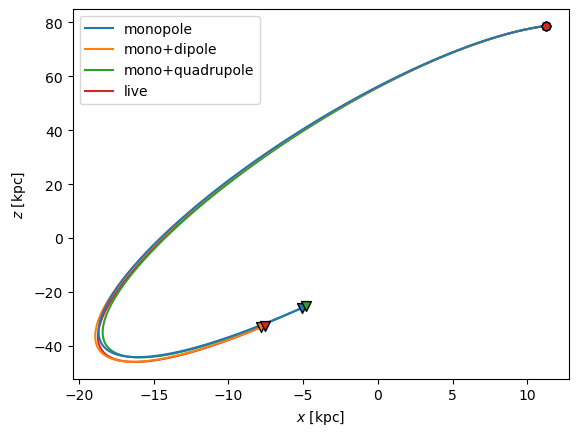

In [12]:
x, y, z, vx, vy, vz = mwlmc_util.radecpms_to_xyzv(ra, dec, dhel, 
                                                  pmra, pmdec, vhel)
pos = [x, y, z]
vel = [vx, vy, vz]

# run the orbit in different potentials 
flags = [0, 1, 2, 63]

fig, ax = plt.subplots()
labels = ['monopole', 'mono+dipole', 'mono+quadrupole', 'live']

for i, flag in enumerate(flags):
    orbit = Model.rewind(pos, vel,
                         mwhharmonicflag=flag, 
                         rewindtime=2, dt=0.001)

    ox, oy, oz = orbit[0], orbit[1], orbit[2]
    ovx, ovy, ovz = orbit[3], orbit[4], orbit[5]
    ofx, ofy, ofz = orbit[6], orbit[7], orbit[8]
    ot = orbit[9]

    # plot orbit
    ax.plot(ox, oz, 
            c='C'+str(i), zorder=20-i, label=labels[i])
    
    # plot start position
    ax.scatter(ox[0], oz[0], 
               c='C'+str(i), marker='o', 
               edgecolors='k', zorder=50)

    # plot end position
    ax.scatter(ox[-1], oz[-1], 
               c='C'+str(i), marker='v', s=50, 
               edgecolors='k', zorder=51)

ax.legend()
ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')
plt.show()

Compare to how orbits deviate in random realisations of initial conditions

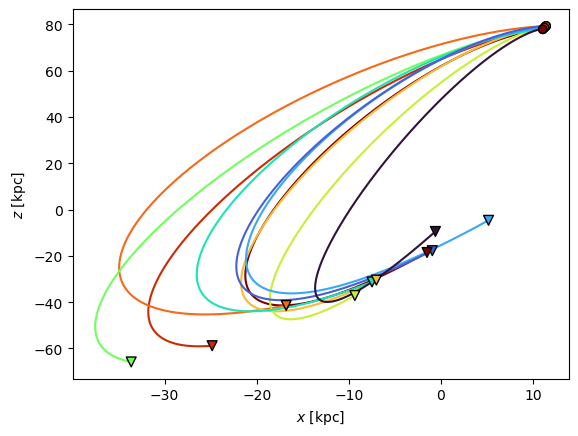

In [13]:
# convert to cartesian coordinates
obs = [ra, dec, dhel, pmra, pmdec, vhel, edhel, epmra, epmdec, evhel]
ra_N, dec_N, dhel_N, pmra_N, pmdec_N, vhel_N = mwlmc_util.make_random_obs(*obs, N=10)

cc = mwlmc_util.radecpms_to_xyzv(ra_N, dec_N, dhel_N, pmra_N, pmdec_N, vhel_N)

pos = np.array(cc[:3]).T
vel = np.array(cc[3:]).T

norbits = len(pos)

# rewind the orbits
X = Model.rewind(pos, vel,
                 mwhharmonicflag=63,
                 rewindtime=2., dt=0.001)
X = np.array(X)


# plot the orbits
colors = plt.cm.turbo(np.linspace(0, 1, norbits))

fig, ax = plt.subplots()

# plot all orbits 
for i in range(norbits)[::-1]:
    ax.plot(X[:,0][i], X[:,2][i], 
            c=colors[i], zorder=20-i)
    
# plot start position
ax.scatter(X[:,0][:,0], X[:,2][:,0], 
           c=colors, marker='o', 
           edgecolors='k', zorder=50)

# plot end position
ax.scatter(X[:,0][:,-1], X[:,2][:,-1], 
           c=colors, marker='v', s=50, 
           edgecolors='k', zorder=50)


ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

plt.show()


As we see, the changes in the orbits are bigger for random draws within the observational error that the changes due to different potentials.

### Carina 3 - long term LMC satellite 

The next example is Carina 3. This is a LMC satellite [(see e.g. Patel et al 2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...893..121P/abstract). They provide 
cartesian coordinates that we will use:

In [14]:
x = 8.29
ex = 0.0 
y = -26.6
ey = 1.24 
z = -8.06
ez = 0.37 
vx = -10.7
evx = 18.9 
vy = -151.85
evy = 8.41 
vz = 356.05
evz = 25.9

A question we could ask here is; is the uncertainty in the distance to the LMC 
dominated by the observational uncertainty or the deforming potential?



First, we get the LMC trajectory for the same rewind time and the same time step
as our rewind run will be.

In [15]:
torb_dt, lmcx_dt, lmcy_dt, lmcz_dt = Model.get_lmc_trajectory(
    rewindtime = 2.5, dt = 0.001).T
r_dt = (lmcx_dt**2 + lmcy_dt**2 + lmcz_dt**2)**(0.5)


We run the same $N$ random realisations in the live and in the monopole 
potential:

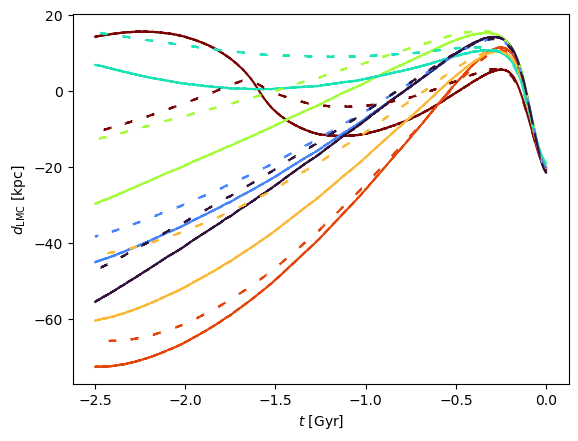

In [16]:
rng = np.random.default_rng(265)
N = 7

# get random draws
obs = [x, y, z, vx, vy, vz]
eobs = [ex, ey, ez, evx, evy, evz]
res = []
for obs, eobs in zip(obs, eobs):
    res.append(rng.normal(obs, scale=eobs, size=N))
    
pos = np.array(res[:3]).T
vel = np.array(res[3:]).T

colors = plt.cm.turbo(np.linspace(0, 1, N))

fig, ax = plt.subplots()

### fully live 
X = Model.rewind(pos, vel,
                 discframe=True, # somehow a turned off discframe makes the orbits wobbly, possibly due to the substraction of r_dt
                 mwhharmonicflag=63,
                 rewindtime=2.5, 
                 dt=0.001)

X = np.array(X)

# plot orbits 
for i in range(N)[::-1]:
    r = (X[:,0][i]**2 + X[:,1][i]**2 + X[:,2][i]**2)**0.5
    ax.plot(X[:,-1][i], 
            r-r_dt, 
            c=colors[i], zorder=20-i)

### monopole orbits
X = Model.rewind(pos, vel,
                 mwhharmonicflag=0, 
                 discframe=True, # somehow a turned off discframe makes the orbits wobbly, possibly due to the substraction of r_dt
                 rewindtime=2.5, 
                 dt=0.001
                )
X = np.array(X)

# plot orbits
for i in range(N)[::-1]:
    r = (X[:,0][i]**2 + X[:,1][i]**2 + X[:,2][i]**2)**0.5
    ax.plot(X[:,-1][i],
            r-r_dt,
            ls = (0, (5, 10)),
            c=colors[i], zorder=30-i)
    
ax.set_xlabel('$t$ [Gyr]')
ax.set_ylabel('$d_\mathrm{LMC}$ [kpc]')
plt.show()

The live orbits are the full and the monopole orbits are the dashed lines. While
there can be differences between the potentials (e.g. orange or dark purple), 
the variety of randomly drawn orbits is still larger.